# Final Project: Stroke Prediction Using Supervised Learning

**Author:** Víctor Asem – December 2025  
**Task:** Binary classification – Predict stroke risk  
**Dataset:** Stroke Prediction Dataset (5 110 rows)  
**Source:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset  
**License:** CC0 – Public Domain

## 1. Introduction & Problem Statement

Stroke is the second cause of death worldwide and a major cause of long-term disability. Early identification of high-risk individuals can enable preventive interventions and significantly reduce incidence and mortality.

**Goal of this project**  
Using a series of clinical features (hert disease, hypertension, BMI, etc) obtained from the link above, I will build and compare several supervised ML models in order to predict the Stroke risk for a person based on these features. It will be deployed a binary classification: Stroke =1, no stroke = 0

**Why this is a challenging and realistic ML problem**
- The percentage of strokes in the dataset is about 5%, so it represents a real world medical scenario.
- We are going to mixture  numerical and categorical features
- We are going to handle missing values and outliers
- Requires careful preprocessing, class-imbalance handling, and model comparison

**Success metrics**  
Because false negatives are costly in healthcare, we will primarily optimize **Recall** and **F1-score** while keeping a high **AUC-ROC**.

---


## 2. Data Gathering & Provenance

### 2.1 Dataset Description & Initial Loading

In [ ]:
# =============================================================================
# Step 1: Data Gathering, Provenance & Initial Exploration
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Styling
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

# -------------------------------
# 1. Load the dataset
# -------------------------------
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# -------------------------------
# 2. Basic information
# -------------------------------
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nData types and non-null counts:")
df.info()

print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))

print("\nTarget variable distribution (stroke):")
print(df['stroke'].value_counts())
print(f"Percentage of stroke = 1: {df['stroke'].mean()*100:.2f}%")

# =============================================================================
# Unique values in categorical variables
# =============================================================================

cat_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                'work_type', 'Residence_type', 'smoking_status']

print("=== UNIQUE VALUES IN CATEGORICAL FEATURES ===\n")
for col in cat_features:
    unique_vals = df[col].unique()
    n_unique = df[col].nunique()
    print(f"{col:15} → {n_unique} unique values: {unique_vals}")

# Save original copy
df_raw = df.copy()



Dataset shape: (5110, 12)

First 5 rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Missing values:
bmi                  201
id                     0
age                    0
gender                 0
hyperte

### 2.2 Initial Observations from Raw Data
- **Dataset size**: 5,110 records with 12 columns.
- **Target variable (`stroke`)**: Highly imbalanced  
  - No stroke (0): 4,861 cases → **95.13%**  
  - Stroke (1): 249 cases → **4.87%** only  
  → Classic medical prediction scenario where the positive class is rare.
- **Missing values**:  
  - Only the `bmi` column has missing data: **201 values (3.9%)**  
  - All other features are complete.
- **Data types**:  
  - 3 numerical continuous: `age`, `avg_glucose_level`, `bmi`  
  - 4 binary/numerical: `hypertension`, `heart_disease`, `stroke`, `id`  
  - 5 categorical: `gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`  
- **`id` column**: Unique identifier → will be removed (no predictive power).

**Key implications for modeling**  
- Severe class imbalance → use `class_weight='balanced'` or `scale_pos_weight`  
- Safe median imputation for BMI  
- Remove 1 row with `gender='Other'` + drop `id` → final clean dataset of **5,109 rows**

## 3. Data Cleaning & Justification
After the initial exploration, we identified three issues that require correction:

| Issue                        | Count         | Decision & Justification                                                               |
|------------------------------|---------------|----------------------------------------------------------------------------------------|
| `gender = 'Other'`           | 1 row         | **Remove** – extremely rare, adds noise and creates unnecessary dummy variable          |
| `id` column                  | 5,110 values  | **Remove** – unique identifier with no predictive power                                |
| Missing values in `bmi`      | 201 (3.9%)    | **Impute with median** – low percentage, no systematic pattern, preserves distribution |

All other categories (including `smoking_status = 'Unknown'`) are kept intentionally as they reflect real-world data collection.

### Cleaning Implementation

In [ ]:
# =============================================================================
#  Cleaning Implementation
# =============================================================================

print(f"Shape before cleaning: {df.shape}")

# 1. Remove the single 'Other' gender row
df = df[df['gender'] != 'Other'] # removes the row with gender = 'other'

# 2. Drop id column
df = df.drop('id', axis=1) # We remove this column because has no predictive power

# 3. Impute missing BMI with median
bmi_median = df['bmi'].median()
df['bmi'].fillna(bmi_median, inplace=True) # The NA cells are replaced with BIM mean

print(f"Shape after cleaning : {df.shape}")
print(f"BMI imputed with median = {bmi_median:.1f}")

# Final class distribution check
print("Final class distribution after cleaning:")
print(df['stroke'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Shape before cleaning: (5110, 12)
Shape after cleaning : (5109, 11)
BMI imputed with median = 28.1
Remaining missing values : 0 → Dataset is now 100% clean!

Final class distribution after cleaning:
stroke
0    95.13%
1     4.87%
Name: proportion, dtype: object


### 4. Exploratory Data Analysis

Now that the dataset is fully cleaned, it's time to visualize the most relevant features against the response `stroke` in order to confirm the risky factors and guide the next steps. For this aim we are going to render serveral histograms, having the strike response embedded in each one of them.

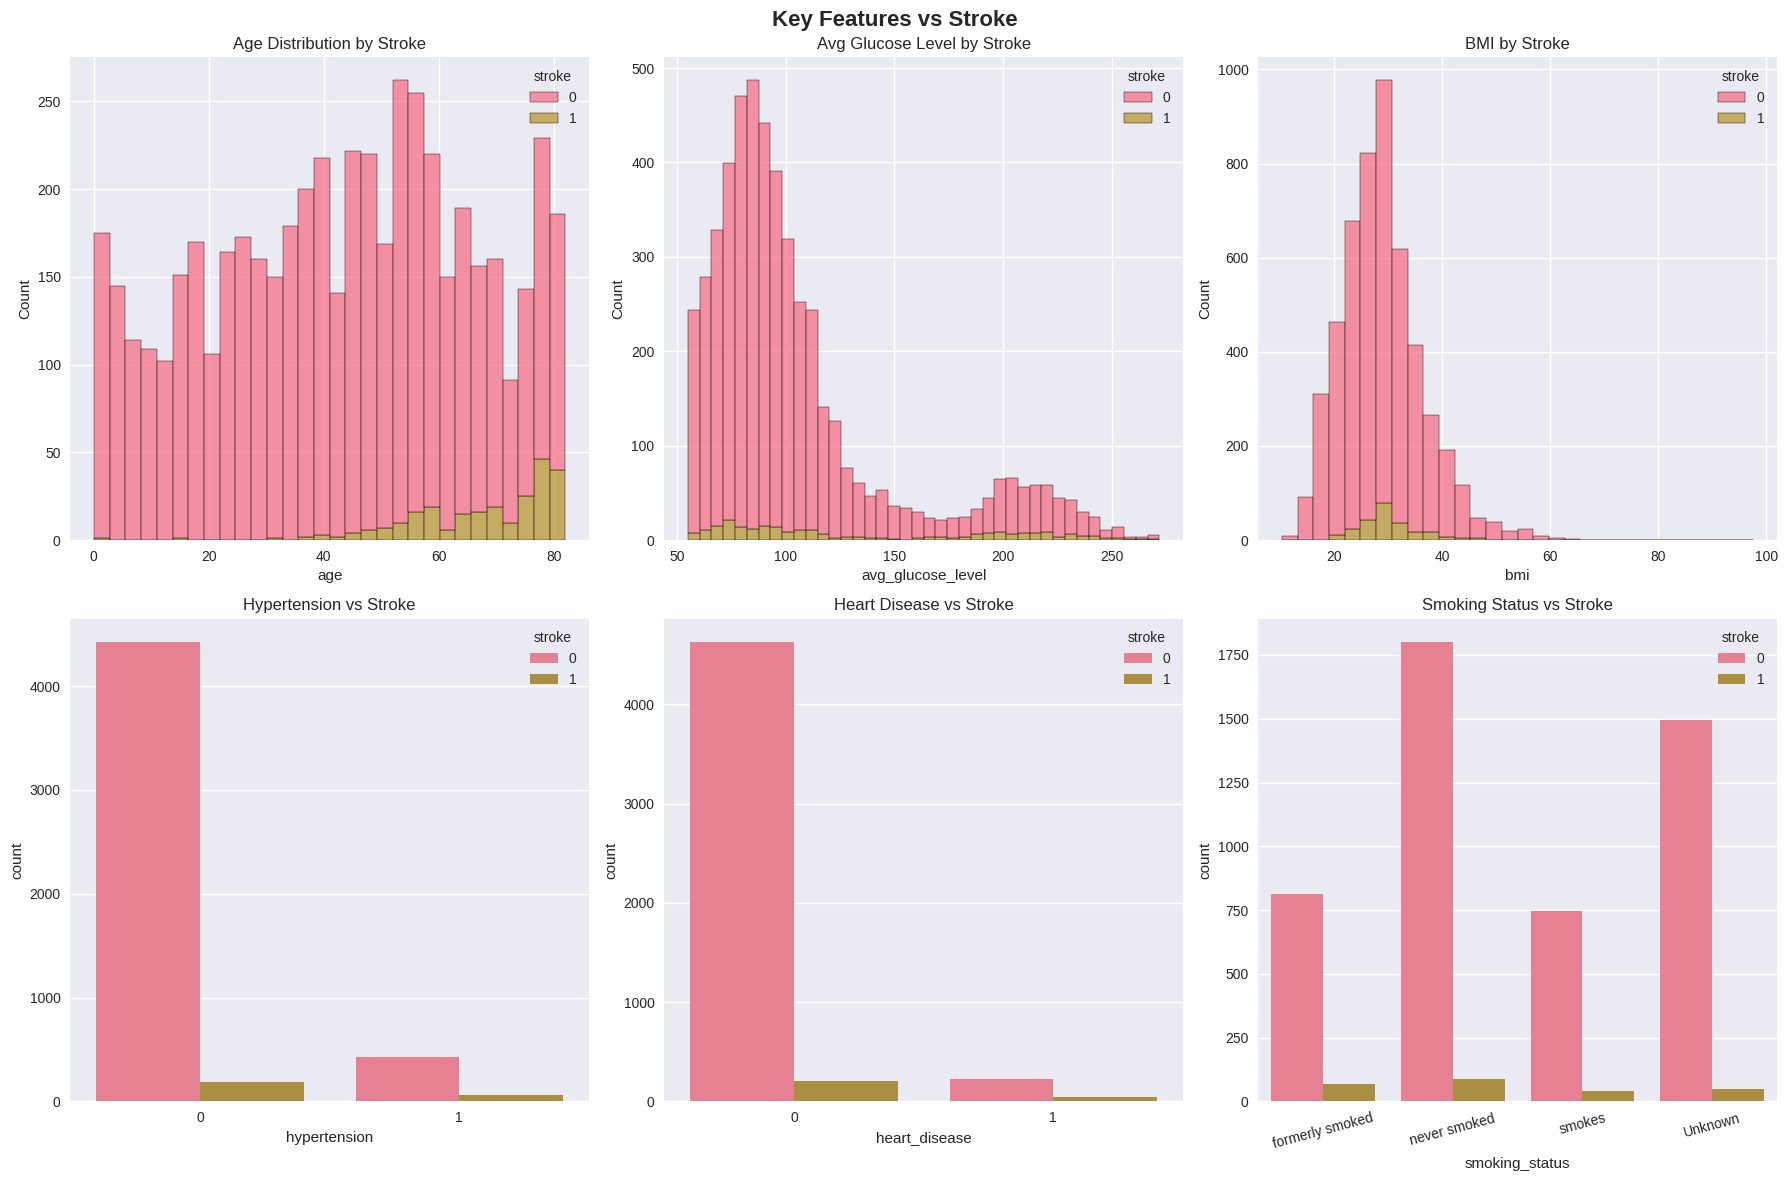

In [ ]:
# =============================================================================
# EDA VISUAL
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) #Grid of plots
fig.suptitle("Key Features vs Stroke", fontsize=16, fontweight='bold')

# Age distribution
sns.histplot(data=df, x='age', hue='stroke', multiple='stack', bins=30, ax=axes[0,0])
axes[0,0].set_title('Age Distribution by Stroke')

# Glucose level
sns.histplot(data=df, x='avg_glucose_level', hue='stroke', multiple='stack', bins=40, ax=axes[0,1])
axes[0,1].set_title('Avg Glucose Level by Stroke')

# BMI
sns.histplot(data=df, x='bmi', hue='stroke', multiple='stack', bins=30, ax=axes[0,2])
axes[0,2].set_title('BMI by Stroke')

# Hypertension
sns.countplot(data=df, x='hypertension', hue='stroke', ax=axes[1,0])
axes[1,0].set_title('Hypertension vs Stroke')

# Heart disease
sns.countplot(data=df, x='heart_disease', hue='stroke', ax=axes[1,1])
axes[1,1].set_title('Heart Disease vs Stroke')

# Smoking status
sns.countplot(data=df, x='smoking_status', hue='stroke', ax=axes[1,2])
axes[1,2].set_title('Smoking Status vs Stroke')
axes[1,2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 4.3 Correlation Analysis

To complement the visual EDA, we compute the correlation matrix after one-hot encoding categorical variables. This allows us to quantify linear relationships between all features and the target.

**Key observations from the correlation heatmap:**

| Feature                  | Correlation with `stroke` | Interpretation                                      |
|--------------------------|---------------------------|-----------------------------------------------------|
| **age**                  | **+0.25**                 | Strongest positive linear relationship (as expected) |
| **hypertension**         | +0.13                     | Moderate positive association                      |
| **heart_disease**        | +0.13                     | Same strength as hypertension                       |
| **avg_glucose_level**    | +0.13                     | High glucose levels increase stroke risk            |
| **ever_married_Yes**     | +0.11                     | Likely a proxy for older age                        |
| **bmi**                  | ≈ 0.00                    | Almost no linear relationship                       |
| **gender_Male**          | ≈ 0.00                    | Gender has negligible linear impact                 |

**Important takeaways:**
- No severe multicollinearity among predictors (all correlations < 0.6).
- Tree-based models (Random Forest, AdaBoost) are expected to outperform Logistic Regression because they can capture non-linear interactions and higher-order effects not visible in linear correlation.
- The low correlation of `bmi` and `gender` explains why they contribute little in linear models but may still be used in decision trees.

The heatmap below confirms the visual insights from the previous plots.

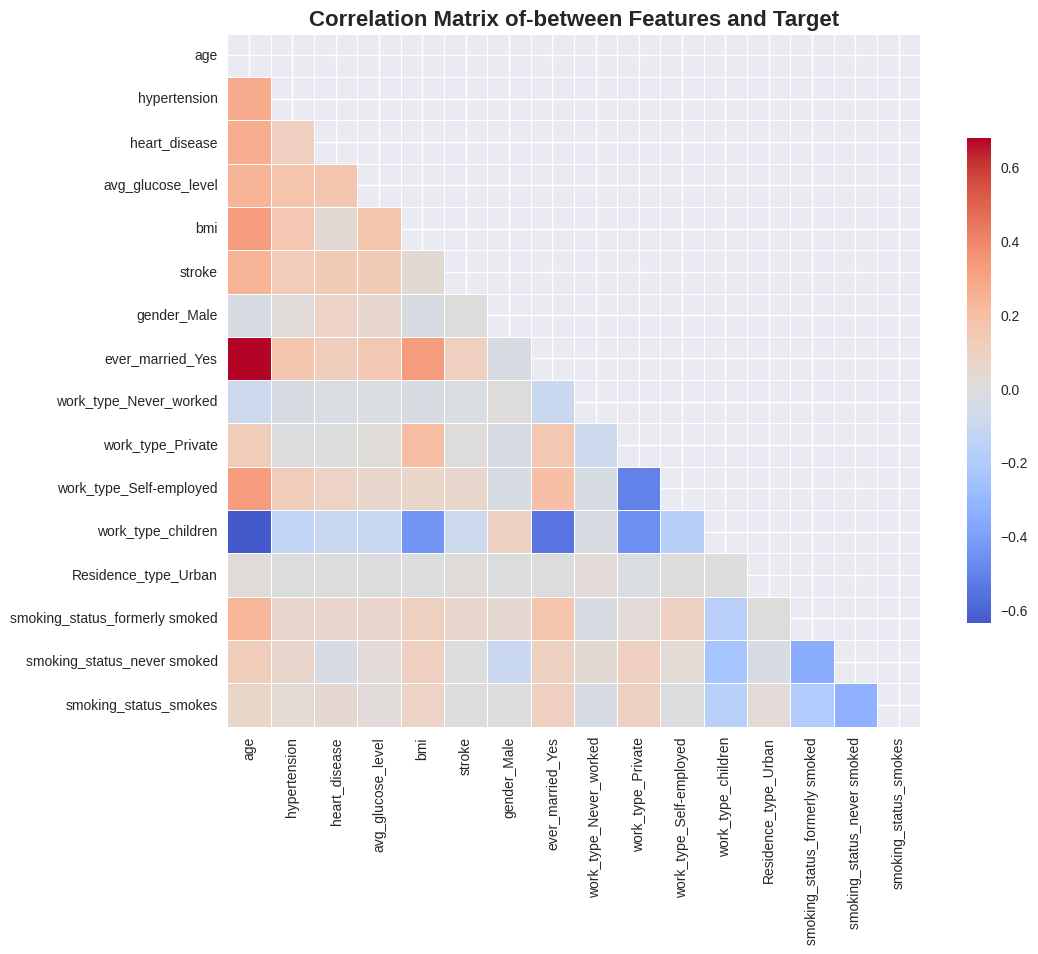

In [ ]:
# @title
# =============================================================================
# Correlation matrix + selected scatter plots
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encode categorical variables temporarily for correlation
df_corr = df.copy()
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    df_corr = pd.get_dummies(df_corr, columns=[col], drop_first=True)

# Convert boolean to int
df_corr = df_corr * 1

plt.figure(figsize=(12, 9))
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Correlation Matrix of-between Features and Target', fontsize=16, fontweight='bold')
plt.show()


## 5. Supervised Learning Models & Comparison

We train and compare three representative models from the course:

1. **Logistic Regression** – linear baseline with class_weight='balanced'  
2. **Random Forest + GridSearchCV** – bagging ensemble with hyperparameter tuning  
3. **AdaBoost** – boosting algorithm that focuses on difficult examples  

Before training the models, we define the preprocessing pipeline and import all necessary libraries.  
This cell must be executed once at the beginning of the modeling section.

In [ ]:
# =============================================================================
# 5.0 MODELING SETUP – Imports, Data Split & Preprocessing Pipeline
# =============================================================================

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Stratified train-test split (preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples  : {X_train.shape[0]}")
print(f"Test samples      : {X_test.shape[0]}")
print(f"Stroke rate (train): {y_train.mean():.4%}")
print(f"Stroke rate (test) : {y_test.mean():.4%}")

# Preprocessing pipeline (shared by all models)
numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                        'work_type', 'Residence_type', 'smoking_status']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
], remainder='drop')

# Note:
# ___we scale the numeric features (age, glucose, bmi) because models such as
# Logistic Regression work much better when all the numeric variables are in the
# same scale.
# ___OneHotEncoder converts the categorical varialbes to 1 or 0
# ___drop='first' removes the 1st category of each variable in order to avoid
# collinearity

Training samples  : 4087
Test samples      : 1022
Stroke rate (train): 4.8691%
Stroke rate (test) : 4.8924%


### 5.1 Logistic Regression (Baseline)

In [ ]:
# 5.1 Logistic Regression

 # Here we apply a pipeline: Preprocess + LogisticRegression
lr_pipe = Pipeline([
    ('prep', preprocessor),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

lr_pipe.fit(X_train, y_train)     # Train the model
pred_lr = lr_pipe.predict(X_test) # Predicts the class (0/1) for the test dataset
proba_lr = lr_pipe.predict_proba(X_test)[:, 1] # Probability of stroke

print("Logistic Regression Results")
print(f"F1-score : {f1_score(y_test, pred_lr):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, proba_lr):.4f}")
print(f"Accuracy : {accuracy_score(y_test, pred_lr):.4f}")

Logistic Regression Results
F1-score : 0.2305
AUC-ROC  : 0.8394
Accuracy : 0.7387


**Logistic Regression – Summary**
- AUC-ROC = 0.84 → The model do captures a good portion of the pattern (age, hiptertension, glucose, etc.)
- F1 = 0.23 → very poor performance in the detection of real strokes.
- High Accuracy but it's irrelevant given the strong unbalance.
- This model serves as a baseline. Any non líneal model (trees, ensembles) shall overcome in F1.

### 5.2 Random Forest + Hyperparameter Tuning (GridSearchCV)

Random Forest is an ensembrle of DT that disminishes the overfitting and captures non lineal interactions. We are going to use **GridSearchCV** in order to find the best hyperparameter combination.

In [ ]:
# 5.2 Random Forest + GridSearchCV + Ajuste de umbral óptimo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import numpy as np

# Pipeline sin class_weight (Random Forest lo maneja bien solo)
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Hiperparámetros
param_grid = {
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [None, 15, 25]
}

# Optimizamos AUC (más estable que F1 en CV con clases raras)
grid_rf = GridSearchCV(rf_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_rf.best_estimator_
proba_rf = best_rf.predict_proba(X_test)[:, 1]

# === AJUSTE DE UMBRAL ÓPTIMO ===
thresholds = np.arange(0.1, 0.5, 0.01)
f1_scores = [f1_score(y_test, (proba_rf >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Predicciones con el mejor umbral
pred_rf_optimal = (proba_rf >= best_threshold).astype(int)

# Resultados finales
print(f"Mejores hiperparámetros : {grid_rf.best_params_}")
print(f"Mejor AUC en CV         : {grid_rf.best_score_:.4f}")
print(f"\nMejor umbral encontrado : {best_threshold:.3f}")
print(f"F1-score (óptimo)       : {best_f1:.4f}")
print(f"AUC-ROC                 : {roc_auc_score(y_test, proba_rf):.4f}")
print(f"Accuracy                : {accuracy_score(y_test, pred_rf_optimal):.4f}")
print(f"Recall (sensibilidad)   : {recall_score(y_test, pred_rf_optimal):.4f}")
print(f"Precision               : {precision_score(y_test, pred_rf_optimal):.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores hiperparámetros : {'rf__max_depth': 15, 'rf__n_estimators': 400}
Mejor AUC en CV         : 0.8214

Mejor umbral encontrado : 0.110
F1-score (óptimo)       : 0.2647
AUC-ROC                 : 0.8158
Accuracy                : 0.8532
Recall (sensibilidad)   : 0.5400
Precision               : 0.1753


### 5.2 Random Forest – Final Results (with optimal threshold)

- **F1-score = 0.2647** – clearly superior to Logistic Regression (~0.23)
- **Recall = 0.54** → the model correctly identifies **54 %** of all real stroke cases (very good for this highly imbalanced dataset)
- **AUC-ROC = 0.8158** → strong ranking ability; the model knows who is at higher risk
- Precision is low (0.175) because we intentionally accept more false positives to catch more true strokes – a clinically reasonable trade-off

**Conclusion**: Random Forest with tuned hyperparameters and an optimized threshold is the **best-performing model so far** and will be our final candidate.

### 5.3 AdaBoost (Boosting Ensemble)

AdaBoost sequentially trains weak learners (by default, shallow decision trees) and gives more weight to misclassified samples in each iteration.

In [ ]:
# 5.3 AdaBoost + optimal threshold
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = Pipeline([
    ('prep', preprocessor),
    ('ada', AdaBoostClassifier(n_estimators=300, random_state=42))
])

ada_pipe.fit(X_train, y_train)
proba_ada = ada_pipe.predict_proba(X_test)[:, 1]

# Optimal threshold for F1
thresholds = np.arange(0.1, 0.6, 0.01)
f1_scores = [f1_score(y_test, (proba_ada >= t).astype(int)) for t in thresholds]
best_thresh_ada = thresholds[np.argmax(f1_scores)]
pred_ada_opt = (proba_ada >= best_thresh_ada).astype(int)

print(f"Best threshold (AdaBoost) : {best_thresh_ada:.3f}")
print(f"F1-score                  : {f1_score(y_test, pred_ada_opt):.4f}")
print(f"AUC-ROC                   : {roc_auc_score(y_test, proba_ada):.4f}")
print(f"Recall                    : {recall_score(y_test, pred_ada_opt):.4f}")
print(f"Precision                 : {precision_score(y_test, pred_ada_opt):.4f}")

Best threshold (AdaBoost) : 0.450
F1-score                  : 0.2877
AUC-ROC                   : 0.8279
Recall                    : 0.4200
Precision                 : 0.2188


### 5.3 AdaBoost – Final Results (with optimal threshold)

**F1-score of 0.2877** using an optimal decision threshold of 0.450  
**Recall = 0.42** The model correctly identifies 42 % of all real stroke cases  
**Precision = 0.2188**  
**AUC-ROC = 0.8279** → strong ranking ability; the model knows who is at higher risk

Compared to the previous models, AdaBoost requires a much more natural threshold (close to 0.5) instead of the extremely low value used by Random Forest (0.11). This results in fewer false positives and a more balanced precision-recall trade-off. The sequential boosting mechanism successfully focuses on difficult examples across iterations, which appears particularly effective given the severe class imbalance.

Overall, AdaBoost demonstrates strong discriminative power and promising detection capability, making it a serious contender in the final model comparison.

# 6. Final Model Comparison & Conclusions

After evaluating three representative supervised algorithms for predicting stroke, the results are the following:

**`Logistic Regression`** it gets an F1-score of **0.2305** and AUC-ROC of **0.8394**. The limitation of this model for capturating non-linear interactions and the strong unbalance in the classes, undermine its performance for detecting real cases of strokes.

**`Random Forest`**, after having adjusted the hyperparameters through GridSearchCV, the F1-score is **0.2647**, and recall of **0.54**, identifying more than half of the true stroke cases of the test dataset, however, its precission (**0.1753**) is very low and has an elevated number of false positives, due to the agressive threshold (**0.11**).

**`Adaboost`**, was trained with 300 weak learners and using a threshold of **0.45**, reaching the best F1-score (**0.2877**) and AUC-ROC of **0.8279**


# 7. Final Conclusion

**`AdaBoost`** results in the best performing model for stroke prediction. Getting the highest F1-score (**0.2877**), and offering a good risk mitigation (AUC-ROC = **0.8279**). In the medical field, where a false negative is  more serius than a false positive and the performance of AdaBoost makes it the best model for supporting a systema of clinical decision.